In [1]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from aijack.attack import GradientInversion_Attack
from aijack.utils import NumpyDataset

In [2]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=588, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            nn.BatchNorm2d(12),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 3

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


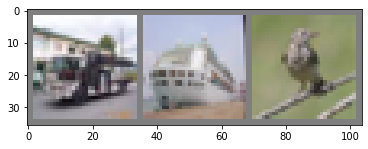

truck ship  bird 


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = images.cuda(), labels.cuda()

# show images
imshow(torchvision.utils.make_grid(images.cpu()))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
def draw_out(attacker, received_gradients, batch_size=0):
    num_seeds=3
    fig = plt.figure()
    fig.set_figheight(7)
    fig.set_figwidth(7)
    for s in tqdm(range(num_seeds)):
        attacker.reset_seed(s)
        if batch_size > 0:
            result = attacker.attack(received_gradients, batch_size=batch_size)
        else:
            result = attacker.attack(received_gradients)
        ax1 = fig.add_subplot(3, num_seeds, s+1)
        test_img = torch.from_numpy((result[0].cpu().detach().numpy()[0])) / 2 + 0.5
        img1 = test_img.swapaxes(0,1)
        img1 = img1.swapaxes(1,2)
        ax1.imshow(torchvision.utils.make_grid(img1))
        ax1.set_title(torch.argmax(result[1]).item())
        ax1.axis("off")
        ax2 = fig.add_subplot(3, num_seeds, num_seeds+s+1)
        ax2.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
        ax2.axis("off")
        ax3 = fig.add_subplot(3, num_seeds, num_seeds + num_seeds+s+1)
        ax3.imshow(cv2.medianBlur(result[0].cpu().detach().numpy()[0][0], 5), cmap="gray")
        ax3.axis("off")
    plt.suptitle("Result")
    plt.tight_layout()
    plt.show()

## DLG Attack
https://dlg.mit.edu/assets/NeurIPS19_deep_leakage_from_gradients.pdf

- distance metric = L2 norm
- optimize both of images and labels

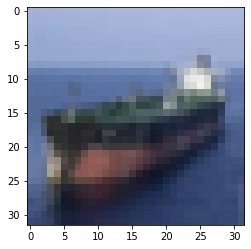

Target


  0%|          | 0/3 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter=246: loss did not improve in the last 50 rounds.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter=225: loss did not improve in the last 50 rounds.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter=163: loss did not improve in the last 50 rounds.


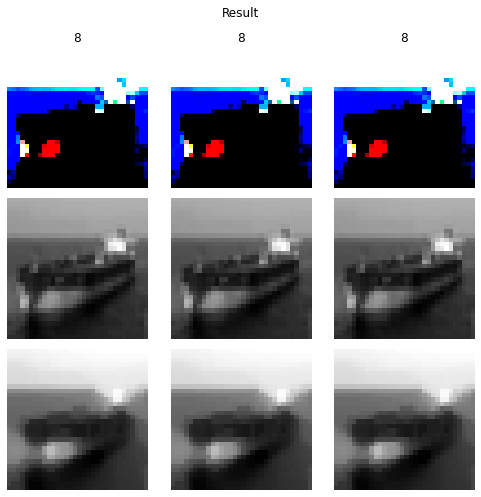

In [7]:
imshow(torchvision.utils.make_grid(images[0].cpu()))
print("Target")
criterion = nn.CrossEntropyLoss()
net = LeNet(channel=3, hideen=768, num_classes=10)
net.to(device)
pred = net(images[:1])
loss = criterion(pred, labels[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

dlg_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=1.0, log_interval=0,
                                    num_iteration=1000,
                                    distancename="l2", device=device)

draw_out(dlg_attacker, received_gradients)

## GS Attack
https://arxiv.org/abs/2003.14053
- distance metric = cosine similarity
- optimize both of images and labels
- total-variance regularization

In [8]:
# imshow(torchvision.utils.make_grid(images[0].cpu()))

# criterion = nn.CrossEntropyLoss()
# net = LeNet(channel=3, hideen=768, num_classes=10)
# net.to(device)
# pred = net(images[:1])
# loss = criterion(pred, labels[:1])
# received_gradients = torch.autograd.grad(loss, net.parameters())
# received_gradients = [cg.detach() for cg in received_gradients]

# gs_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=1.0, log_interval=0,
#                                     num_iteration=200,
#                                     tv_reg_coef=0.01,
#                                     distancename="cossim", device=device)

# draw_out(gs_attacker, received_gradients)

## IDLG Attack
https://arxiv.org/abs/2001.02610
- distance metric = L2 norm
- optimize only an image & estimate a label from the gradients

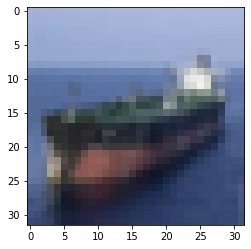

  0%|          | 0/3 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


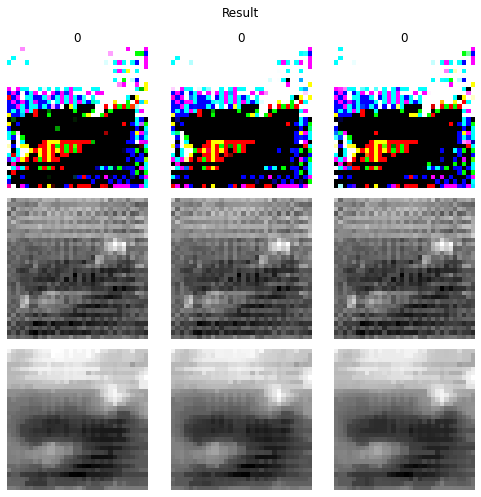

In [9]:
imshow(torchvision.utils.make_grid(images[0].cpu()))

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=3, hideen=768, num_classes=10)
net.to(device)
pred = net(images[:1])
loss = criterion(pred, labels[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

idlg_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=10e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=10000, device=device)

draw_out(idlg_attacker, received_gradients)

## CPL Attack
https://arxiv.org/abs/2004.10397
- distance metric = L2 norm
- optimize only images & estimate an label from the gradients
- label-matching regularization

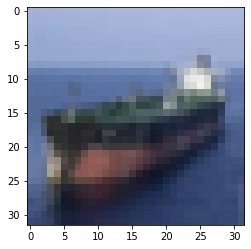

  0%|          | 0/3 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


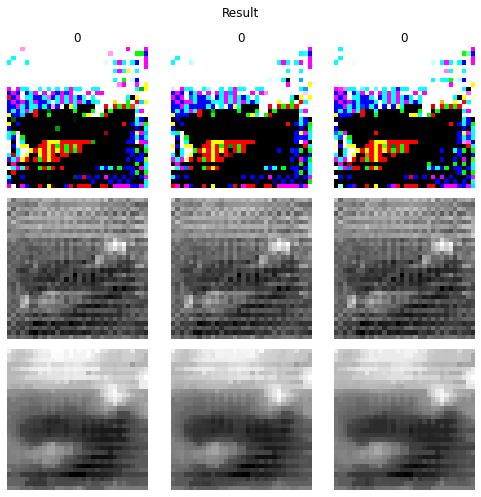

In [10]:
import torch.optim as optim

imshow(torchvision.utils.make_grid(images[0].cpu()))

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=3, hideen=768, num_classes=10)
net.to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.1)
# for epoch in range(10):
pred = net(images[:1])
loss = criterion(pred, labels[:1])
loss.backward(retain_graph=True)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach()for cg in received_gradients]

cpl_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=10e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=10000,
                                    lm_reg_coef=0.01, device=device)

draw_out(cpl_attacker, received_gradients)

    # optimizer.step()


## Test Atk

In [11]:
# import torch.optim as optim

# imshow(torchvision.utils.make_grid(images[0:3].cpu()))

# criterion = nn.CrossEntropyLoss()
# net = LeNet(channel=3, hideen=768, num_classes=10)
# net.to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.1)
# for epoch in range(3):
#     pred = net(images[:1])

#     loss = criterion(pred, labels[:1])
#     loss.backward(retain_graph=True)

#     received_gradients = torch.autograd.grad(loss, net.parameters())
#     received_gradients = [cg.detach()/(-0.1)  for cg in received_gradients]
    
#     optimizer.step()
    
# cpl_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=10e2, log_interval=0,
#                                     optimizer_class=torch.optim.SGD,
#                                     distancename="l2", optimize_label=False,
#                                     num_iteration=10000,
#                                     lm_reg_coef=0.01, device=device)

# draw_out(cpl_attacker, received_gradients, batch_size=3)
    
# gradinversion = GradientInversion_Attack(net, (3, 32, 32), num_iteration=1900,
#                                         lr=1e2, log_interval=0,
#                                         optimizer_class=torch.optim.SGD,
#                                         distancename="l2", optimize_label=False,
#                                         bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
#                                         group_num = 3,
#                                         tv_reg_coef=0.00, l2_reg_coef=0.0001,
#                                         bn_reg_coef=0.001, gc_reg_coef=0.001, device=device)

# result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

# fig = plt.figure()
# for bid in range(batch_size):
#     ax1 = fig.add_subplot(2, batch_size, bid+1)
#     test_img = torch.from_numpy(((sum(result[0]) / len(result[0])).cpu().detach().numpy()[bid]))
#     img1 = test_img.swapaxes(0,1)
#     img1 = img1.swapaxes(1,2)
#     ax1.imshow(torchvision.utils.make_grid(img1))
#     ax1.set_title(result[1][0][bid].item())
#     ax1.axis("off")
#     ax2 = fig.add_subplot(2, batch_size, batch_size+bid+1)
#     ax2.imshow((sum(result[0]) / len(result[0])).cpu().detach().numpy()[bid][0], cmap="gray")
#     ax2.axis("off")

## GradInversion
https://arxiv.org/abs/2104.07586
- distance metric = L2 norm
- optimize only images & estimate labels from the gradients
- total-variance, l2, bn, and group-consistency regularization

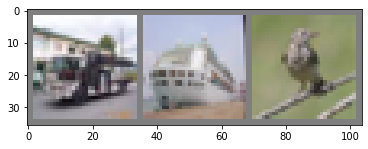

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Result of GradInversion')

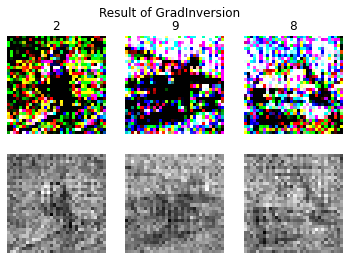

In [7]:
batch_size = 3

imshow(torchvision.utils.make_grid(images[:3].cpu()))

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=3, hideen=768, num_classes=10)
net.to(device)
pred = net(images[:batch_size])
loss = criterion(pred, labels[:batch_size])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

gradinversion = GradientInversion_Attack(net, (3, 32, 32), num_iteration=1900,
                                    lr=1e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
                                    group_num = 3,
                                    tv_reg_coef=0.00, l2_reg_coef=0.0001,
                                    bn_reg_coef=0.001, gc_reg_coef=0.001, device=device)

result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

fig = plt.figure()
for bid in range(batch_size):
    ax1 = fig.add_subplot(2, batch_size, bid+1)
    test_img = torch.from_numpy(((sum(result[0]) / len(result[0])).cpu().detach().numpy()[bid]))
    img1 = test_img.swapaxes(0,1)
    img1 = img1.swapaxes(1,2)
    ax1.imshow(torchvision.utils.make_grid(img1))
    ax1.set_title(result[1][0][bid].item())
    ax1.axis("off")
    ax2 = fig.add_subplot(2, batch_size, batch_size+bid+1)
    ax2.imshow((sum(result[0]) / len(result[0])).cpu().detach().numpy()[bid][0], cmap="gray")
    ax2.axis("off")

plt.suptitle("Result of GradInversion")